In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import pearsonr
from counterbalance import CounterbalancedStratifiedSplit
%matplotlib inline

In [105]:
N = 1000
y = np.repeat([0, 1], repeats=N/2)

clf = LogisticRegression()
yweights = [0, 0.5, 1, 1.5, 2, 2.5]
cweights = [0, 0.5, 1, 1.5, 2, 2.5]
cyweights = [0, 0.5, 1, 1.5, 2, 2.5]
N_elem = len(yweights) * len(cweights) * len(cyweights) * 10 * 3

res = dict(score=np.zeros(N_elem), method=np.zeros(N_elem),
           cyweights=np.zeros(N_elem), yweights=np.zeros(N_elem), cweights=np.zeros(N_elem))

this_i = 0
for i, cyweight in enumerate(cyweights):
    print('%i / %i' % (i+1, len(cyweights)))
    c = np.random.normal(0, 1, N) + y * cyweight
    for ii, cweight in enumerate(cweights):
        
        for iii, yweight in enumerate(yweights):
            X = y * yweight + c * cweight
            X = X[:, np.newaxis]

            folds = StratifiedKFold(n_splits=10)
            for ii, (train_idx, test_idx) in enumerate(folds.split(X, y)):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                c_train, c_test = c[train_idx], c[test_idx]
                btrain = np.linalg.lstsq(c_train[:, np.newaxis], X_train)[0]
                X_train_resid = X_train - c_train[:, np.newaxis].dot(btrain)
                X_test_resid = X_test - c_test[:, np.newaxis].dot(btrain)

                clf.fit(X_train, y_train)
                res['score'][this_i] = clf.score(X_test, y_test)
                res['method'][this_i] = 0
                res['cweights'][this_i] = cweight
                res['yweights'][this_i] = yweight
                res['cyweights'][this_i] = cyweight
                this_i += 1
                
                clf.fit(X_train_resid, y_train)
                res['score'][this_i] = clf.score(X_test_resid, y_test)
                res['method'][this_i] = 1
                res['cweights'][this_i] = cweight
                res['yweights'][this_i] = yweight
                res['cyweights'][this_i] = cyweight
                this_i += 1
                
            cbss = CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=10, c_type='continuous')
            cbss.check_counterbalance_and_subsample()
            for ii, (train_idx, test_idx) in enumerate(cbss.split(X, y)):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                clf.fit(X_train, y_train)
                res['score'][this_i] = clf.score(X_test, y_test)
                res['method'][this_i] = 2
                res['cweights'][this_i] = cweight
                res['yweights'][this_i] = yweight
                res['cyweights'][this_i] = cyweight
                this_i += 1

1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


/home/lukas/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


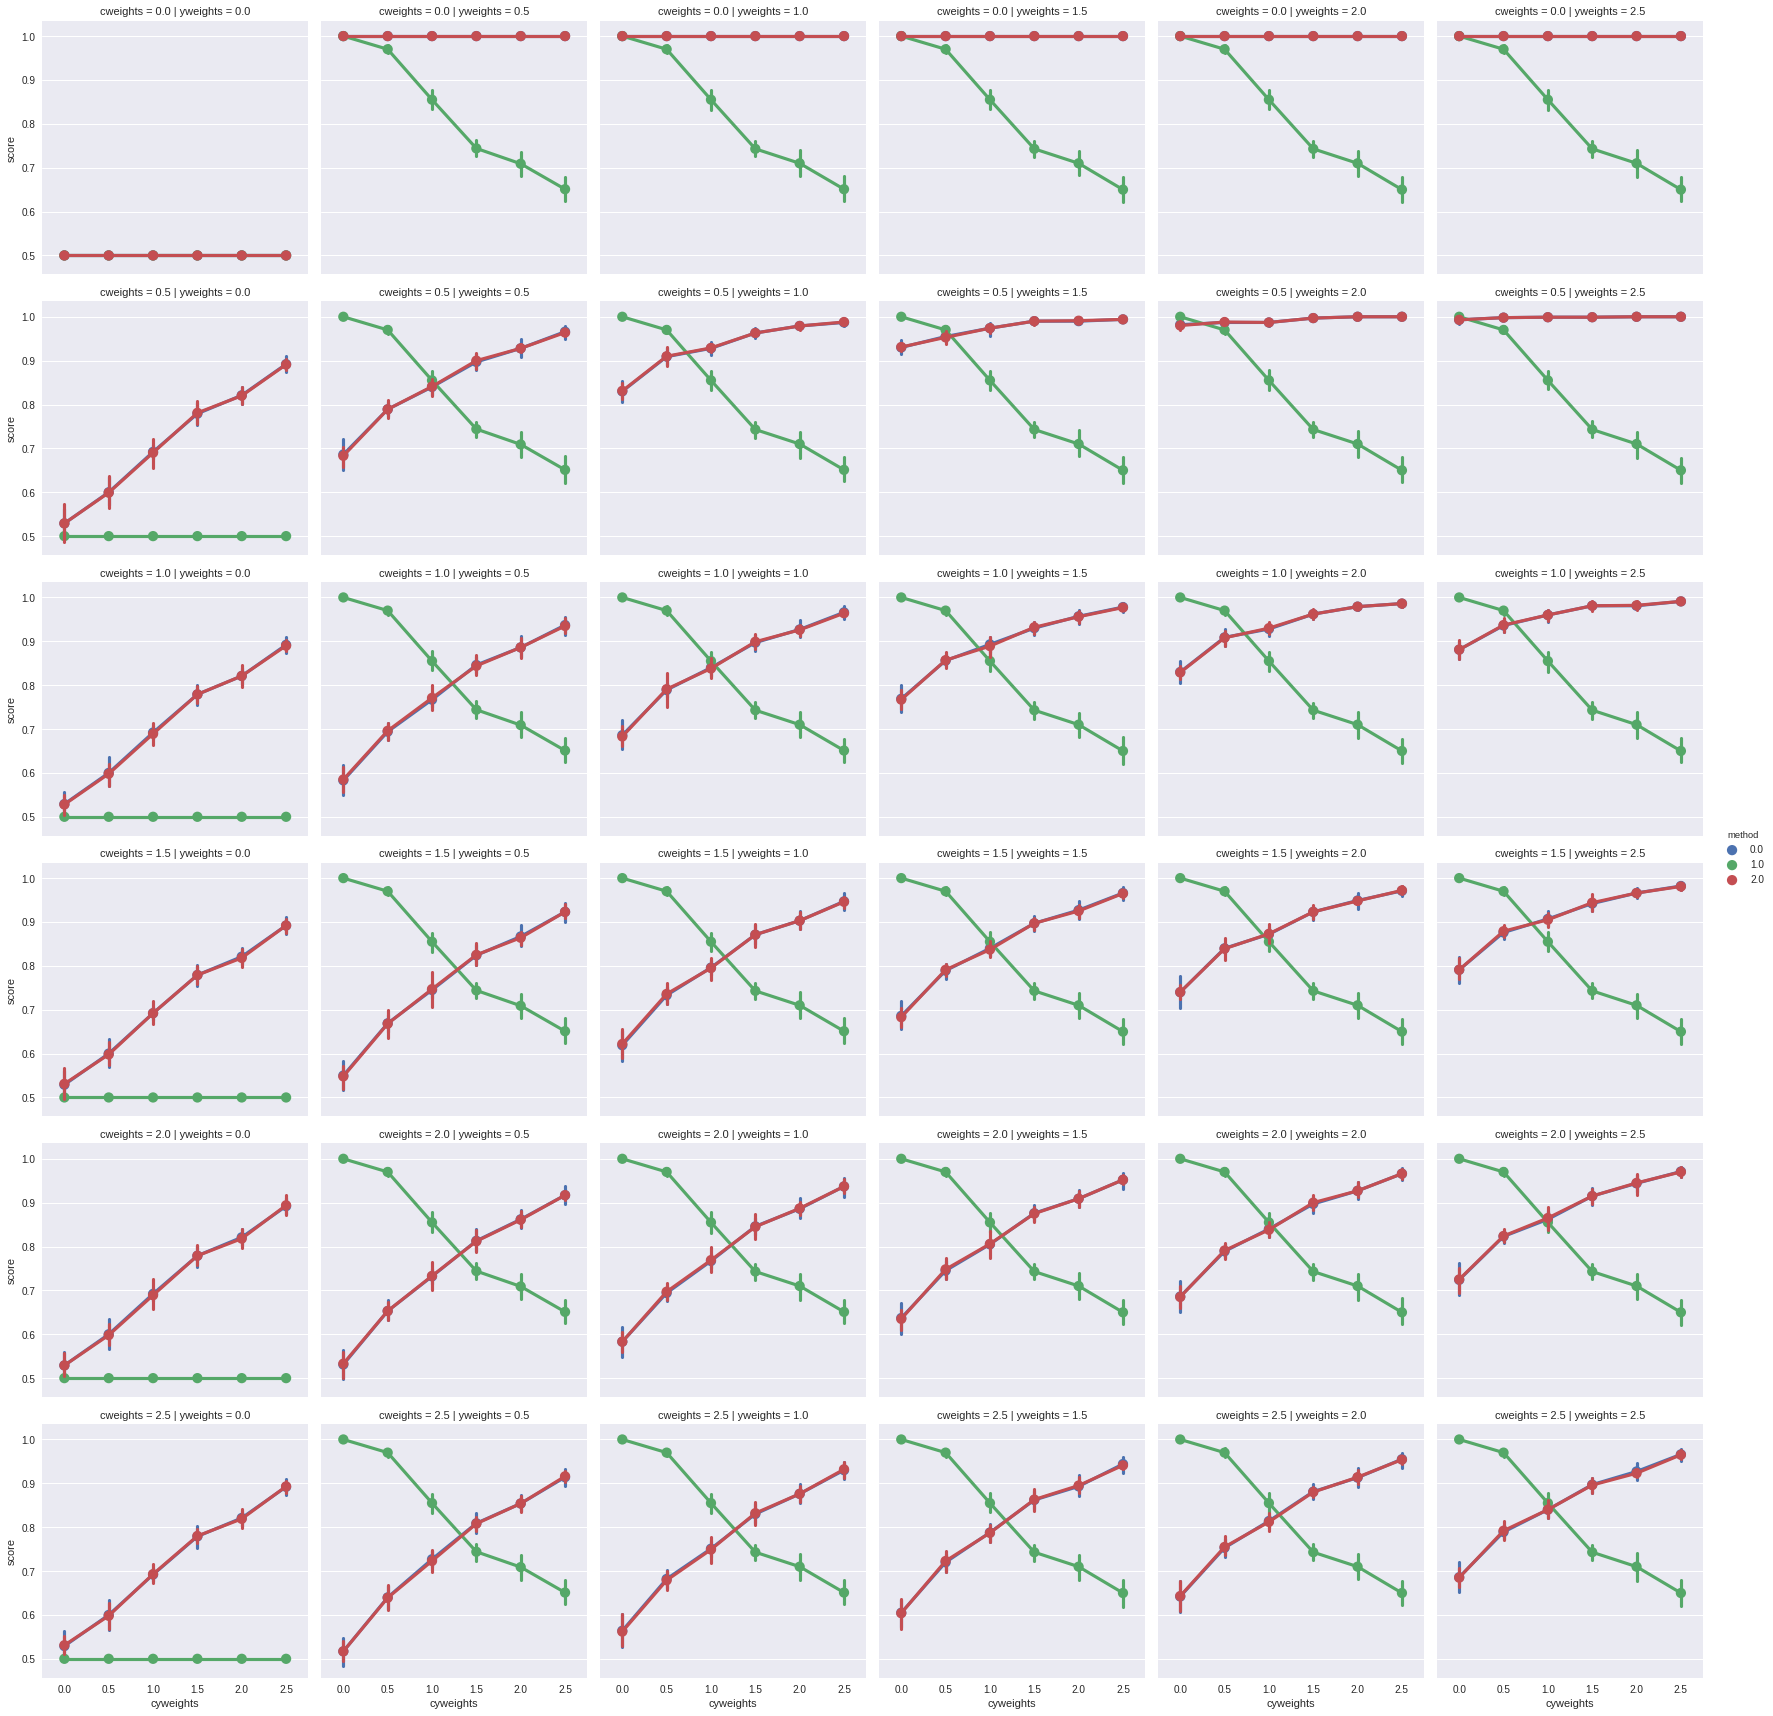

In [106]:
import seaborn as sns
import pandas as pd
sns.factorplot(data=pd.DataFrame(res), y='score', x='cyweights', row='cweights', col='yweights', hue='method')